In [123]:
import numpy as np
import pandas as pd
import plotly.express as px
from scipy.fftpack import fft#푸리에 변환을 위한 코드입니다.
from scipy.stats import boxcox#박스콕스 변환을 위한 코드임
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
# ===== LightGBM 머신러닝 파이프라인 =====
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import plotly.graph_objects as go
import plotly.express as px
import optuna
from optuna.samplers import TPESampler
from sklearn.linear_model import Ridge
from statsmodels.tsa.seasonal import STL
from sklearn.svm import SVR
#기타
import warnings
warnings.filterwarnings('ignore')

In [159]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVR
from tqdm import tqdm
from statsmodels.tsa.seasonal import STL
from numpy.fft import fft

# 1. 데이터 불러오기 및 기본 전처리
df_train = pd.read_csv("train_heat.csv")
df_test = pd.read_csv("test_heat.csv")
df_train.columns = df_train.columns.str.replace('train_heat.', '', regex=False)
df_train = df_train.drop(columns=["Unnamed: 0"])
df_test.columns = [
    "tm", "branch_id", "ta", "wd", "ws",
    "rn_day", "rn_hr1", "hm", "si", "ta_chi","heat_demand"
]
df_train = df_train[df_train['branch_id'] == 'B'].copy()
df_test = df_test[df_test['branch_id'] == 'B'].copy()

# 2. STL 시계열 분해 함수 (heat_demand는 제외)
def create_time_series_features(df, target_cols=['ta', 'ws'], freq_hours=23):
    print(f"🔄 STL 시계열 분해 특성 생성 중... (대상: {target_cols})")
    print("=" * 60)
    print("⚠️ heat_demand는 테스트 데이터에 없으므로 제외됩니다.")
    df_features = df.copy()
    for branch in tqdm(sorted(df['branch_id'].unique()), desc="브랜치별 STL 분해"):
        branch_mask = df_features['branch_id'] == branch
        branch_data = df_features[branch_mask].copy().sort_values('tm')
        if len(branch_data) < freq_hours * 7:
            print(f"   ⚠️ 브랜치 {branch}: 데이터 부족 ({len(branch_data)}개) - 건너뜀")
            continue
        for col in target_cols:
            if col not in branch_data.columns:
                continue
            try:
                col_data = branch_data[col].interpolate().fillna(method='bfill').fillna(method='ffill')
                ts_data = col_data.copy()
                ts_data.index = pd.to_datetime(branch_data['tm'])
                stl = STL(ts_data, seasonal=freq_hours, robust=True)
                stl_result = stl.fit()
                indices = branch_data.index
                df_features.loc[indices, f'{col}_stl_trend'] = stl_result.trend.values
                df_features.loc[indices, f'{col}_stl_seasonal'] = stl_result.seasonal.values
                df_features.loc[indices, f'{col}_stl_resid'] = stl_result.resid.values
                df_features.loc[indices, f'{col}_detrend'] = col_data.values - stl_result.trend.values
                df_features.loc[indices, f'{col}_seasonal_strength'] = np.abs(stl_result.seasonal.values)
                seasonal_std = np.std(stl_result.seasonal.values)
                df_features.loc[indices, f'{col}_seasonal_volatility'] = seasonal_std
            except Exception as e:
                print(f"      ⚠️ STL 분해 실패 ({col}): {str(e)[:50]}")
                continue
    time_series_features = [col for col in df_features.columns 
                           if any(pattern in col for pattern in ['_stl_', '_detrend', '_seasonal_strength', '_seasonal_volatility'])]
    print(f"\n✅ STL 시계열 분해 완료!")
    print(f"📊 생성된 시계열 특성: {len(time_series_features)}개")
    print(f"📋 특성 목록: {time_series_features[:10]}{'...' if len(time_series_features) > 10 else ''}")
    return df_features, time_series_features

# 3. 날씨 데이터 전처리 함수 (heat_demand는 파생변수/보간 등에서 제외)
def preprocess_weather_data(df):
    df['tm'] = pd.to_datetime(df['tm'], format='%Y%m%d%H')
    mask_outside_8_to_18 = (~df['tm'].dt.hour.between(8, 18)) & (df['si'] == -99)
    df.loc[mask_outside_8_to_18, 'si'] = 0
    df['wd'] = df['wd'].replace(9.9, np.nan)
    df.replace(-99, np.nan, inplace=True)
    df = df.sort_values(['branch_id', 'tm'])

    # heat_demand는 numeric_cols에서 제외!
    numeric_cols = ['ta', 'wd', 'ws', 'rn_day', 'rn_hr1', 'hm', 'si', 'ta_chi']

    for branch in df['branch_id'].unique():
        print(f"   🏢 브랜치 {branch} SVR 보간 중...", end=" ")
        branch_mask = df['branch_id'] == branch
        branch_data = df[branch_mask].copy()
        branch_data['hour'] = branch_data['tm'].dt.hour
        branch_data['day_of_year'] = branch_data['tm'].dt.dayofyear
        branch_data['month'] = branch_data['tm'].dt.month
        for col in numeric_cols:
            if col in branch_data.columns:
                missing_mask = branch_data[col].isna()
                if missing_mask.sum() > 0:
                    train_mask = ~missing_mask
                    X_train = branch_data.loc[train_mask, ['hour', 'day_of_year', 'month']].values
                    y_train = branch_data.loc[train_mask, col].values
                    X_pred = branch_data.loc[missing_mask, ['hour', 'day_of_year', 'month']].values
                    try:
                        scaler_X = StandardScaler()
                        scaler_y = StandardScaler()
                        X_train_scaled = scaler_X.fit_transform(X_train)
                        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
                        svr = SVR(kernel='rbf', C=1.0, gamma='scale')
                        svr.fit(X_train_scaled, y_train_scaled)
                        X_pred_scaled = scaler_X.transform(X_pred)
                        y_pred_scaled = svr.predict(X_pred_scaled)
                        y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
                        df.loc[branch_mask & missing_mask, col] = y_pred
                    except Exception as e:
                        print(f"\n   ⚠️ {col} SVR 실패 → 선형 보간 대체")
                        df.loc[branch_mask, col] = df.loc[branch_mask, col].interpolate(method='linear')
                df.loc[branch_mask, col] = df.loc[branch_mask, col].fillna(method='ffill').fillna(method='bfill')
        print("✅")

    print("🎉 SVR 보간 완료 (heat_demand는 제외)")

    # 파생변수 생성 (cat_cols 포함)
    df['year'] = df['tm'].dt.year
    df['month'] = df['tm'].dt.month
    df['day'] = df['tm'].dt.day
    df['hour'] = df['tm'].dt.hour
    df['weekday'] = df['tm'].dt.weekday
    df['is_weekend'] = df['weekday'].isin([5,6]).astype(int)
    # peak_time1
    df['peak_time1'] = 0
    df.loc[(df['hour'] >= 0) & (df['hour'] <= 6), 'peak_time1'] = 1
    df.loc[(df['hour'] > 6) & (df['hour'] <= 11), 'peak_time1'] = 2
    df.loc[(df['hour'] > 11) & (df['hour'] <= 18), 'peak_time1'] = 3
    df.loc[(df['hour'] > 18) & (df['hour'] <= 23), 'peak_time1'] = 4
    # peak_time2
    df['peak_time2'] = 0
    df.loc[(df['hour'] >= 2) & (df['hour'] <= 10), 'peak_time2'] = 1
    # heating_season
    df['heating_season'] = df['month'].isin([10,11,12,1,2,3,4]).astype(int)
    # temp_category
    df['temp_category20'] = pd.cut(df['ta'], bins=[-np.inf, 20, np.inf], labels=['low', 'high'])
    df['temp_category18'] = pd.cut(df['ta'], bins=[-np.inf, 18, np.inf], labels=['low', 'high'])
    df['temp_category16'] = pd.cut(df['ta'], bins=[-np.inf, 16, np.inf], labels=['low', 'high'])
    # afternoon
    df['afternoon'] = (df['hour'] >= 12).astype(int)

    # STL 시계열 분해
    print("🚀 STL 시계열 분해 시작...")
    df, ts_features = create_time_series_features(df, target_cols=['ta', 'ws'])
        # 🔽 파생변수 추가 (NEW)

    # 1. 이동 평균 기온
    df = df.sort_values(['branch_id', 'tm']).copy()
    df['ta_mean_3h'] = df.groupby('branch_id')['ta'].transform(lambda x: x.rolling(3, min_periods=1).mean())
    df['ta_mean_6h'] = df.groupby('branch_id')['ta'].transform(lambda x: x.rolling(6, min_periods=1).mean())
    df['ta_mean_12h'] = df.groupby('branch_id')['ta'].transform(lambda x: x.rolling(12, min_periods=1).mean())

    # 2. 체감온도 추정치 (풍속 * 기온 차이)
    df['windchill'] = df['ws'] * (20 - df['ta'])
    df['ta_diff_1h'] = df.groupby('branch_id')['ta'].diff(1)
    df['ta_diff_3h'] = df.groupby('branch_id')['ta'].diff(3)
    df['ws_diff_1h'] = df.groupby('branch_id')['ws'].diff(1)
    df['ws_diff_3h'] = df.groupby('branch_id')['ws'].diff(3)
    df['day_of_year'] = df['tm'].dt.dayofyear
    df['seasonal_center'] = abs(df['day_of_year'] - 183) / 183
    df['season_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    df['season_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
    # 🔥 [파생변수: 겨울 극한/여름 과대예측 보정용] 🔥

    # 1. 누적 한랭(Heating Degree Hour, HDH)
    df['hdh_18'] = np.maximum(18 - df['ta'], 0)
    df['hdh_18_24h'] = df.groupby('branch_id')['hdh_18'].transform(lambda x: x.rolling(24, min_periods=1).sum())
    df['hdh_18_72h'] = df.groupby('branch_id')['hdh_18'].transform(lambda x: x.rolling(72, min_periods=1).sum())

    # 2. 급격한 온도 하락/상승 감지
    df['ta_drop_6h'] = df.groupby('branch_id')['ta'].diff(6)
    df['ta_drop_12h'] = df.groupby('branch_id')['ta'].diff(12)
    df['ta_drop_6h_only'] = df['ta_drop_6h'].apply(lambda x: x if x < 0 else 0)
    df['ta_drop_12h_only'] = df['ta_drop_12h'].apply(lambda x: x if x < 0 else 0)

    # 3. 체감온도 기반 극한 한파 감지
    df['windchill'] = 13.12 + 0.6215*df['ta'] - 11.37*(df['ws']**0.16) + 0.3965*df['ta']*(df['ws']**0.16)
    df['extreme_cold_0'] = (df['windchill'] <= 0).astype(int)
    df['extreme_cold_m5'] = (df['windchill'] <= -5).astype(int)
    df['extreme_cold_m10'] = (df['windchill'] <= -10).astype(int)

    # 4. 여름철 온수 수요 구간 구분
    df['is_summer'] = df['month'].isin([6,7,8]).astype(int)
    df['low_demand_summer'] = ((df['is_summer'] == 1) & (df['ta'] > 22)).astype(int)

    # 6. 한파/폭염 이벤트 플래그
    df['mean_ta_3d'] = df.groupby('branch_id')['ta'].transform(lambda x: x.rolling(24*3, min_periods=1).mean())
    df['cold_wave_flag'] = (df['mean_ta_3d'] <= 0).astype(int)
    df['heat_wave_flag'] = (df['mean_ta_3d'] >= 28).astype(int)
    # 필요 없는 컬럼만 drop (cat_cols는 남김)
    df = df.drop(columns=['day','hour','ws_stl_trend','hm'] ) 

    return df

# 4. 전처리 함수 적용 (log1p 변환 전!)
df_train = preprocess_weather_data(df_train)
df_test = preprocess_weather_data(df_test)



# 6. 범주형 변수 지정
cat_cols = [
    'peak_time1', 'peak_time2', 'heating_season','month',
    'temp_category16', 'temp_category18', 'temp_category20','afternoon'
]
exclude_cols = ['heat_demand'] + cat_cols
num_cols = [col for col in df_train.columns
            if (df_train[col].dtype in [np.float64, np.int64]) and (col not in exclude_cols)]

for col in cat_cols:
    if col in df_train.columns:
        df_train[col] = df_train[col].astype('category')
    if col in df_test.columns:
        df_test[col] = df_test[col].astype('category')

# 7. OneHotEncoder
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
ohe.fit(df_train[cat_cols])
train_cat = ohe.transform(df_train[cat_cols])
test_cat = ohe.transform(df_test[cat_cols])
ohe_columns = ohe.get_feature_names_out(cat_cols)
df_train_cat = pd.DataFrame(train_cat, columns=ohe_columns, index=df_train.index)
df_test_cat = pd.DataFrame(test_cat, columns=ohe_columns, index=df_test.index)
pd.Series(ohe_columns).to_csv("ohe_columns.csv", index=False)

# 8. StandardScaler
scaler = StandardScaler()
scaler.fit(df_train[num_cols])
df_train_num = pd.DataFrame(scaler.transform(df_train[num_cols]), columns=num_cols, index=df_train.index)
df_test_num = pd.DataFrame(scaler.transform(df_test[num_cols]), columns=num_cols, index=df_test.index)

# 9. 나머지 컬럼 (타겟 등)
other_cols = [col for col in df_train.columns if col not in num_cols + cat_cols]
df_train_other = df_train[other_cols]
df_test_other = df_test[other_cols]

# 10. 최종 병합 (인덱스 유지)
df_train_final = pd.concat([df_train_num, df_train_cat, df_train_other], axis=1)
df_test_final = pd.concat([df_test_num, df_test_cat, df_test_other], axis=1)

# 11. 저장
df_train_final.to_csv('df_train_prescale.csv', index=False)
df_test_final.to_csv('df_test_prescale.csv', index=False)

   🏢 브랜치 B SVR 보간 중... ✅
🎉 SVR 보간 완료 (heat_demand는 제외)
🚀 STL 시계열 분해 시작...
🔄 STL 시계열 분해 특성 생성 중... (대상: ['ta', 'ws'])
⚠️ heat_demand는 테스트 데이터에 없으므로 제외됩니다.


브랜치별 STL 분해: 100%|██████████| 1/1 [00:08<00:00,  8.25s/it]



✅ STL 시계열 분해 완료!
📊 생성된 시계열 특성: 12개
📋 특성 목록: ['ta_stl_trend', 'ta_stl_seasonal', 'ta_stl_resid', 'ta_detrend', 'ta_seasonal_strength', 'ta_seasonal_volatility', 'ws_stl_trend', 'ws_stl_seasonal', 'ws_stl_resid', 'ws_detrend']...
   🏢 브랜치 B SVR 보간 중... ✅
🎉 SVR 보간 완료 (heat_demand는 제외)
🚀 STL 시계열 분해 시작...
🔄 STL 시계열 분해 특성 생성 중... (대상: ['ta', 'ws'])
⚠️ heat_demand는 테스트 데이터에 없으므로 제외됩니다.


브랜치별 STL 분해: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it]



✅ STL 시계열 분해 완료!
📊 생성된 시계열 특성: 12개
📋 특성 목록: ['ta_stl_trend', 'ta_stl_seasonal', 'ta_stl_resid', 'ta_detrend', 'ta_seasonal_strength', 'ta_seasonal_volatility', 'ws_stl_trend', 'ws_stl_seasonal', 'ws_stl_resid', 'ws_detrend']...


In [160]:
df_train = pd.read_csv('df_train_prescale.csv')
df=df_train.copy()
df_train = df[df['year'] <= 2022]
df_test = df[df['year'] >= 2023]
df_train = df_train.sort_values(['branch_id', 'tm'])
df_test = df_test.sort_values(['branch_id', 'tm'])
df_train = df_train.drop(columns=['year'])
df_test = df_test.drop(columns=['year'])
df_train = df_train.set_index('tm')
df_test = df_test.set_index('tm')
df_train = df_train.sort_index()
df_test = df_test.sort_index()

In [161]:
print(df_train['heat_demand'].describe())
print(df_test['heat_demand'].describe())

count    17519.000000
mean       235.016496
std        196.866170
min          1.000000
25%         80.000000
50%        156.000000
75%        357.000000
max        966.000000
Name: heat_demand, dtype: float64
count    8760.000000
mean      213.344749
std       179.547775
min         3.000000
25%        73.000000
50%       130.000000
75%       345.000000
max       893.000000
Name: heat_demand, dtype: float64


[I 2025-06-26 20:40:34,670] A new study created in memory with name: no-name-1251e4ef-33d0-49c1-bc66-36370aef7b71


===== Fold 1 =====


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-06-26 20:40:35,670] Trial 0 finished with value: 107.41393720672379 and parameters: {'learning_rate': 0.00727491708802781, 'max_depth': 16, 'min_child_weight': 8, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.7468055921327309, 'gamma': 0.7799726016810132, 'reg_lambda': 0.5808361216819946, 'reg_alpha': 8.661761457749352}. Best is trial 0 with value: 107.41393720672379.
[I 2025-06-26 20:40:36,686] Trial 1 finished with value: 95.80936067916329 and parameters: {'learning_rate': 0.02416482602989751, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.9909729556485982, 'colsample_bytree': 0.9497327922401265, 'gamma': 1.0616955533913808, 'reg_lambda': 1.8182496720710062, 'reg_alpha': 1.8340450985343382}. Best is trial 1 with value: 95.80936067916329.
[I 2025-06-26 20:40:38,233] Trial 2 finished with value: 100.83769252801751 and parameters: {'learning_rate': 0.005012686302434875, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.7873687420594125, 'colsample_bytree': 

[I 2025-06-26 20:41:21,190] A new study created in memory with name: no-name-f03a2c52-1863-44c5-903e-aa57a0422ad1


Fold 1 RMSE (원래 스케일): 84.3779
===== Fold 2 =====


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-06-26 20:41:22,719] Trial 0 finished with value: 57.591043326930404 and parameters: {'learning_rate': 0.00727491708802781, 'max_depth': 16, 'min_child_weight': 8, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.7468055921327309, 'gamma': 0.7799726016810132, 'reg_lambda': 0.5808361216819946, 'reg_alpha': 8.661761457749352}. Best is trial 0 with value: 57.591043326930404.
[I 2025-06-26 20:41:23,946] Trial 1 finished with value: 67.37212641715229 and parameters: {'learning_rate': 0.02416482602989751, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.9909729556485982, 'colsample_bytree': 0.9497327922401265, 'gamma': 1.0616955533913808, 'reg_lambda': 1.8182496720710062, 'reg_alpha': 1.8340450985343382}. Best is trial 0 with value: 57.591043326930404.
[I 2025-06-26 20:41:25,816] Trial 2 finished with value: 65.0361753300615 and parameters: {'learning_rate': 0.005012686302434875, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.7873687420594125, 'colsample_bytree': 0

[I 2025-06-26 20:42:13,241] A new study created in memory with name: no-name-3cc96fc1-9948-4899-b5b3-538ced868a29


Fold 2 RMSE (원래 스케일): 50.6619
===== Fold 3 =====


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-06-26 20:42:15,149] Trial 0 finished with value: 147.76230648832603 and parameters: {'learning_rate': 0.00727491708802781, 'max_depth': 16, 'min_child_weight': 8, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.7468055921327309, 'gamma': 0.7799726016810132, 'reg_lambda': 0.5808361216819946, 'reg_alpha': 8.661761457749352}. Best is trial 0 with value: 147.76230648832603.
[I 2025-06-26 20:42:16,518] Trial 1 finished with value: 152.28773649739495 and parameters: {'learning_rate': 0.02416482602989751, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.9909729556485982, 'colsample_bytree': 0.9497327922401265, 'gamma': 1.0616955533913808, 'reg_lambda': 1.8182496720710062, 'reg_alpha': 1.8340450985343382}. Best is trial 0 with value: 147.76230648832603.
[I 2025-06-26 20:42:19,024] Trial 2 finished with value: 148.59574459754896 and parameters: {'learning_rate': 0.005012686302434875, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.7873687420594125, 'colsample_bytree'

[I 2025-06-26 20:43:45,694] A new study created in memory with name: no-name-8bc56b73-f142-4914-bf0d-c6107f74fd0d


Fold 3 RMSE (원래 스케일): 142.0060
===== Fold 4 =====


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-06-26 20:43:48,055] Trial 0 finished with value: 38.45518362276973 and parameters: {'learning_rate': 0.00727491708802781, 'max_depth': 16, 'min_child_weight': 8, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.7468055921327309, 'gamma': 0.7799726016810132, 'reg_lambda': 0.5808361216819946, 'reg_alpha': 8.661761457749352}. Best is trial 0 with value: 38.45518362276973.
[I 2025-06-26 20:43:49,654] Trial 1 finished with value: 39.34767001668825 and parameters: {'learning_rate': 0.02416482602989751, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.9909729556485982, 'colsample_bytree': 0.9497327922401265, 'gamma': 1.0616955533913808, 'reg_lambda': 1.8182496720710062, 'reg_alpha': 1.8340450985343382}. Best is trial 0 with value: 38.45518362276973.
[I 2025-06-26 20:43:52,858] Trial 2 finished with value: 38.97202334387612 and parameters: {'learning_rate': 0.005012686302434875, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.7873687420594125, 'colsample_bytree': 0.8

[I 2025-06-26 20:45:03,359] A new study created in memory with name: no-name-423d0fa8-eb84-474c-948c-02665dd1b0bf


Fold 4 RMSE (원래 스케일): 37.1142
===== Fold 5 =====


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-06-26 20:45:05,758] Trial 0 finished with value: 18.503848938453572 and parameters: {'learning_rate': 0.00727491708802781, 'max_depth': 16, 'min_child_weight': 8, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.7468055921327309, 'gamma': 0.7799726016810132, 'reg_lambda': 0.5808361216819946, 'reg_alpha': 8.661761457749352}. Best is trial 0 with value: 18.503848938453572.
[I 2025-06-26 20:45:07,341] Trial 1 finished with value: 18.55671206059953 and parameters: {'learning_rate': 0.02416482602989751, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.9909729556485982, 'colsample_bytree': 0.9497327922401265, 'gamma': 1.0616955533913808, 'reg_lambda': 1.8182496720710062, 'reg_alpha': 1.8340450985343382}. Best is trial 0 with value: 18.503848938453572.
[I 2025-06-26 20:45:10,340] Trial 2 finished with value: 18.466277032774414 and parameters: {'learning_rate': 0.005012686302434875, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.7873687420594125, 'colsample_bytree':

[I 2025-06-26 20:47:05,997] A new study created in memory with name: no-name-9ead617f-218d-4435-b7a3-9f71be23a0f9


Fold 5 RMSE (원래 스케일): 18.1660
===== Fold 6 =====


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-06-26 20:47:08,441] Trial 0 finished with value: 40.9898847802342 and parameters: {'learning_rate': 0.00727491708802781, 'max_depth': 16, 'min_child_weight': 8, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.7468055921327309, 'gamma': 0.7799726016810132, 'reg_lambda': 0.5808361216819946, 'reg_alpha': 8.661761457749352}. Best is trial 0 with value: 40.9898847802342.
[I 2025-06-26 20:47:10,091] Trial 1 finished with value: 40.26502321775765 and parameters: {'learning_rate': 0.02416482602989751, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.9909729556485982, 'colsample_bytree': 0.9497327922401265, 'gamma': 1.0616955533913808, 'reg_lambda': 1.8182496720710062, 'reg_alpha': 1.8340450985343382}. Best is trial 1 with value: 40.26502321775765.
[I 2025-06-26 20:47:13,215] Trial 2 finished with value: 40.54181387006506 and parameters: {'learning_rate': 0.005012686302434875, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.7873687420594125, 'colsample_bytree': 0.883

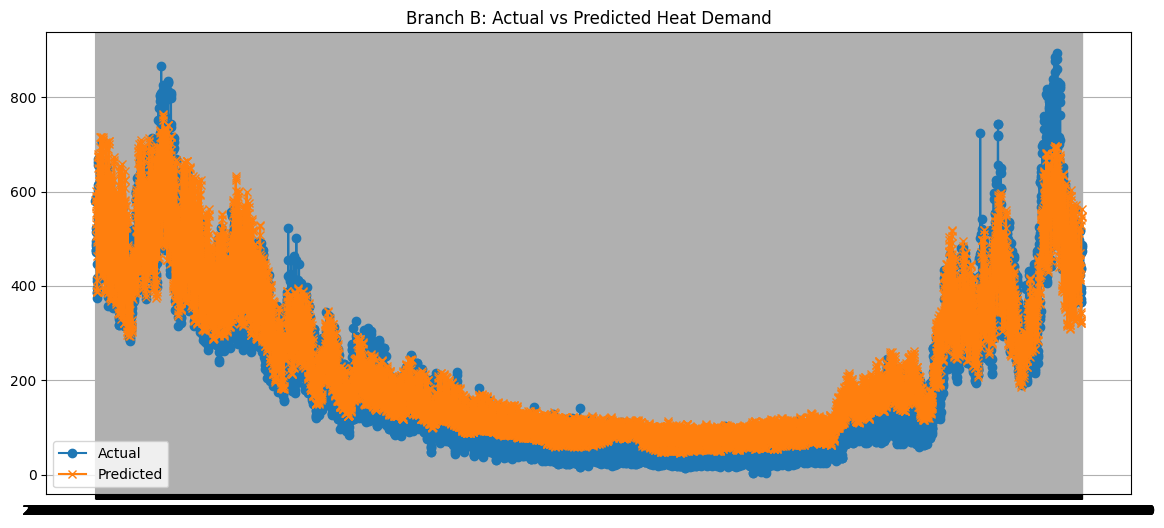

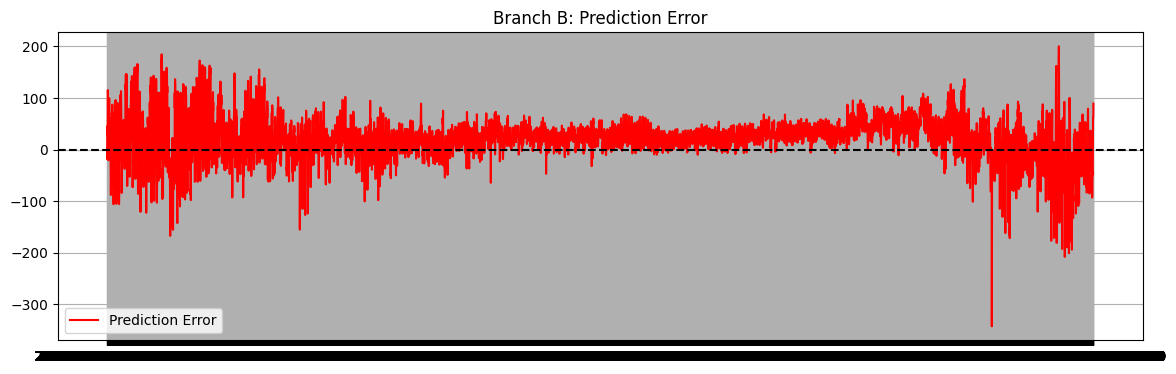

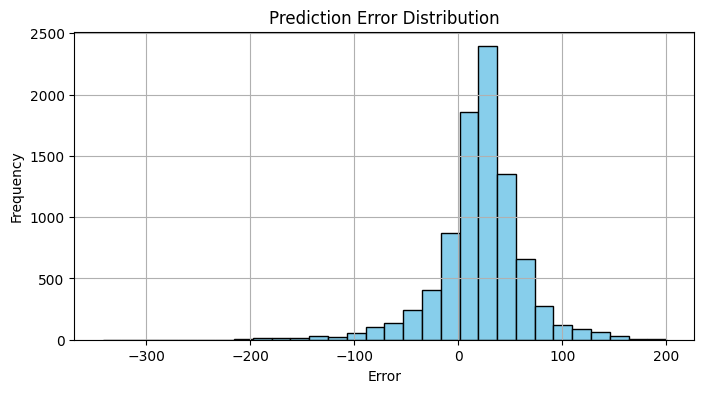

각 Fold의 Validation RMSE (원래 스케일): [84.37794265701937, 50.66185001433524, 142.0060243000275, 37.11422336748912, 18.16597604167954, 39.42143993765084]
최종 평균 Validation RMSE (원래 스케일): 61.957909386366936


In [162]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import pandas as pd
import xgboost as xgb
import optuna
from optuna.samplers import TPESampler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# ----------------------------
# 1. 학습 함수 정의 (학습은 log1p, 평가는 원래 스케일)
# ----------------------------
def run_6fold_pipeline_with_xgb_timeseries(df_train, df_test, target_col='heat_demand'):
    features = [col for col in df_train.columns if col != target_col]

    # ⭐ 원래 스케일 target 따로 저장
    y_orig = df_train[target_col].copy()
    X = df_train[features]
    y_log = np.log1p(y_orig)

    tscv = TimeSeriesSplit(n_splits=6)
    val_rmses = []
    test_preds = []
    xgb_models = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train_log, y_val_log = y_log.iloc[train_idx], y_log.iloc[val_idx]
        y_train_orig, y_val_orig = y_orig.iloc[train_idx], y_orig.iloc[val_idx]  # ✅ 원래 스케일 유지

        print(f"===== Fold {fold+1} =====")

        def xgb_objective(trial):
            params = {
                'objective': 'reg:squarederror',
                'eval_metric': 'rmse',
                'booster': 'gbtree',
                'tree_method': 'hist',
                'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.2, log=True),
                'max_depth': trial.suggest_int('max_depth', 3, 16),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
                'subsample': trial.suggest_float('subsample', 0.7, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
                'gamma': trial.suggest_float('gamma', 0, 5),
                'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
                'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
                'n_estimators': 1000,
                'random_state': 42,
                'n_jobs': -1
            }
            model = xgb.XGBRegressor(**params)
            model.fit(X_train, y_train_log, eval_set=[(X_val, y_val_log)], verbose=False)
            val_pred_log = model.predict(X_val)
            val_pred_orig = np.expm1(val_pred_log)
            return np.sqrt(mean_squared_error(y_val_orig, val_pred_orig))  # ✅ 진짜 원래 스케일로 평가

        study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
        study.optimize(xgb_objective, n_trials=50, show_progress_bar=True)

        best_params = study.best_params
        best_params.update({
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'booster': 'gbtree',
            'tree_method': 'hist',
            'n_estimators': 1000,
            'random_state': 42,
            'n_jobs': -1
        })

        model = xgb.XGBRegressor(**best_params)
        model.fit(X_train, y_train_log, eval_set=[(X_val, y_val_log)], verbose=False)

        val_pred_log = model.predict(X_val)
        val_pred_orig = np.expm1(val_pred_log)
        test_pred_log = model.predict(df_test[features])
        test_pred_orig = np.expm1(test_pred_log)

        val_rmse = np.sqrt(mean_squared_error(y_val_orig, val_pred_orig))
        print(f"Fold {fold+1} RMSE (원래 스케일): {val_rmse:.4f}")

        val_rmses.append(val_rmse)
        test_preds.append(test_pred_orig)
        xgb_models.append(model)

    avg_val_rmse = np.mean(val_rmses)
    avg_test_pred = np.mean(test_preds, axis=0)

    return {
        'val_rmse': avg_val_rmse,
        'val_rmses': val_rmses,
        'test_pred': avg_test_pred,
        'test_index': df_test.index,
        'xgb_models': xgb_models,
        'features': features
    }

# ----------------------------
# 2. 데이터 준비 및 예측 실행
# ----------------------------
branch = 'B'
train_branch = df_train[df_train['branch_id'] == branch].copy()
test_branch = df_test[df_test['branch_id'] == branch].copy()

train_branch = train_branch.drop(columns=['branch_id'])
test_branch = test_branch.drop(columns=['branch_id'])
target_col = 'heat_demand'

results = run_6fold_pipeline_with_xgb_timeseries(train_branch, test_branch, target_col)

# ----------------------------
# 3. 예측값과 실제값 비교
# ----------------------------
test_pred_B = pd.DataFrame({
    'branch_ID': branch,
    'heat_demand': results['test_pred']  # ✅ 이미 원래 스케일임
}, index=results['test_index'])

df_test_B = df_test[df_test['branch_id'] == branch].copy()
df_test_B = df_test_B.sort_index()
test_pred_B = test_pred_B.sort_index()

common_index = df_test_B.index.intersection(test_pred_B.index)

compare_df = df_test_B.loc[common_index, ['heat_demand']].rename(columns={'heat_demand': 'actual'})
compare_df['predicted'] = test_pred_B.loc[common_index, 'heat_demand']  # ✅ logX 아님
compare_df['diff'] = compare_df['predicted'] - compare_df['actual']
compare_df = compare_df.replace([np.inf, -np.inf], np.nan).dropna()

if len(compare_df) == 0:
    print("⚠️ 비교 가능한 데이터가 없습니다.")
else:
    rmse = np.sqrt(np.mean(compare_df['diff'] ** 2))
    mae = np.mean(np.abs(compare_df['diff']))
    print(f"Branch B - RMSE: {rmse:.4f}, MAE: {mae:.4f}")

    # 실제값 vs 예측값 그래프
    plt.figure(figsize=(14, 6))
    plt.plot(compare_df.index, compare_df['actual'], label='Actual', marker='o')
    plt.plot(compare_df.index, compare_df['predicted'], label='Predicted', marker='x')
    plt.title('Branch B: Actual vs Predicted Heat Demand')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 오차 시계열 그래프
    plt.figure(figsize=(14, 4))
    plt.plot(compare_df.index, compare_df['diff'], label='Prediction Error', color='red')
    plt.axhline(0, color='black', linestyle='--')
    plt.title('Branch B: Prediction Error')
    plt.grid(True)
    plt.legend()
    plt.show()

    # 오차 분포 히스토그램
    plt.figure(figsize=(8, 4))
    plt.hist(compare_df['diff'], bins=30, color='skyblue', edgecolor='black')
    plt.title('Prediction Error Distribution')
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

print("각 Fold의 Validation RMSE (원래 스케일):", results['val_rmses'])
print("최종 평균 Validation RMSE (원래 스케일):", results['val_rmse'])


In [163]:
# ----------------------------
# 4. Permutation 중요도 계산 및 음수 중요도 순 정렬
# ----------------------------

from sklearn.inspection import permutation_importance

# 마지막 fold에서 사용된 모델과 validation 데이터 사용
last_model = results['xgb_models'][-1]
last_features = results['features']

# 마지막 fold의 validation 데이터를 다시 정의 (6번째 fold)
X = train_branch[last_features]
y_orig = train_branch[target_col]
y_log = np.log1p(y_orig)

tscv = TimeSeriesSplit(n_splits=6)
splits = list(tscv.split(X))
_, val_idx = splits[-1]  # 마지막 fold

X_val = X.iloc[val_idx]
y_val_log = y_log.iloc[val_idx]
y_val_orig = y_orig.iloc[val_idx]

# permutation importance 계산 (log1p 예측이 아니라, 실제 스케일 예측 기준으로 평가)
def score_func(model, X, y_true):
    pred = np.expm1(model.predict(X))
    return -mean_squared_error(y_true, pred)

# permutation importance 수행
perm_result = permutation_importance(
    last_model,
    X_val,
    y_val_orig,  # 원래 스케일 사용
    n_repeats=30,
    random_state=42,
    scoring='neg_mean_squared_error'  # 음수 MSE로 계산 (높을수록 좋음)
)

perm_df = pd.DataFrame({
    'feature': last_features,
    'importance_mean': perm_result.importances_mean,
    'importance_std': perm_result.importances_std
})

# 중요도가 음수이고, 절댓값이 큰 순서대로 정렬
neg_importance_df = perm_df[perm_df['importance_mean'] < 0].sort_values(by='importance_mean')

# 출력
print("📉 Permutation 중요도가 음수인 변수 (모델 성능 저하에 기여):")
print(neg_importance_df.to_string(index=False))


📉 Permutation 중요도가 음수인 변수 (모델 성능 저하에 기여):
            feature  importance_mean  importance_std
        ta_drop_12h        -1.386979        0.131608
   ta_drop_12h_only        -0.188802        0.032217
        day_of_year        -0.124479        0.011576
        ta_mean_12h        -0.108594        0.032921
                 ws        -0.094531        0.029464
        afternoon_1        -0.058594        0.006299
    ta_drop_6h_only        -0.023438        0.011231
temp_category18_low        -0.022656        0.002344
             rn_hr1        -0.012500        0.006250
